In [16]:
import yfinance as yf
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import concurrent.futures
from datetime import datetime, timedelta
from sklearn.model_selection import ParameterGrid

# Function to download stock data
def download_data(ticker, start_date, end_date, interval='1h'):
    stock_data = yf.download(ticker, start=start_date, end=end_date, interval=interval, progress=False)
    return stock_data

# Function to plot the stock price and buy/sell signals
def plot_signals(signals, ticker):
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(111, ylabel='Price in $')
    signals[['price', 'moving_avg', 'upper_band', 'lower_band']].plot(ax=ax1)
    ax1.plot(signals.loc[signals.positions == 1.0].index, signals.price[signals.positions == 1.0], '^', markersize=10, color='g', label='Buy')
    ax1.plot(signals.loc[signals.positions == -1.0].index, signals.price[signals.positions == -1.0], 'v', markersize=10, color='r', label='Sell')
    plt.title(f'{ticker} Bollinger Bands Mean Reversion Strategy')
    plt.legend(loc='best')
    plt.show()



# Function to implement the Bollinger Bands mean reversion strategy
def bollinger_bands_mean_reversion(stock_data, window, num_std_dev):
    signals = pd.DataFrame(index=stock_data.index)
    signals['price'] = stock_data['Adj Close']
    signals['moving_avg'] = signals['price'].rolling(window=window).mean()
    signals['std_dev'] = signals['price'].rolling(window=window).std()
    signals['upper_band'] = signals['moving_avg'] + (signals['std_dev'] * num_std_dev)
    signals['lower_band'] = signals['moving_avg'] - (signals['std_dev'] * num_std_dev)
    signals['signal'] = 0.0
    signals['signal'] = np.where(signals['price'] < signals['lower_band'], 1.0, 0.0)
    signals['signal'] = np.where(signals['price'] > signals['upper_band'], -1.0, signals['signal'])
    signals['positions'] = signals['signal'].diff()
    return signals

# Function to calculate PnL and simulate trading
def calculate_pnl(signals, initial_investment, transaction_fee_per_share):
    signals['position_diff'] = signals['positions'].diff()
    signals['fees'] = signals['position_diff'].abs() * transaction_fee_per_share
    signals['holdings'] = signals['positions'] * signals['price']
    signals['cash'] = initial_investment - (signals['position_diff'] * signals['price'] + signals['fees']).cumsum()
    signals['total'] = signals['cash'] + signals['holdings']

    signals['trade_duration'] = signals.positions[signals.positions != 0].groupby((signals.positions != 0).cumsum()).cumcount()
    signals['positions'] = np.where(signals.trade_duration >= 5, 0, signals.positions)

    return signals



def single_backtest(ticker, start_date, end_date, window, num_std_dev, initial_investment, transaction_fee_per_share):
    stock_data = download_data(ticker, start_date, end_date)
    
    if stock_data.empty:
        return 0, 0, 0
    
    signals = bollinger_bands_mean_reversion(stock_data, window, num_std_dev)
    signals = calculate_pnl(signals, initial_investment, transaction_fee_per_share)

    pnl = signals['total'][-1] - initial_investment
    profit_rate = pnl / initial_investment
    num_transactions = signals['positions'].abs().sum()

    return pnl, profit_rate, num_transactions

# Function to perform backtests using multithreading
def backtest_strategy(ticker, start_date, end_date, window, num_std_dev, initial_investment, transaction_fee_per_share, n=100):
    pnl_list = []
    profit_rate_list = []
    num_transactions_list = []

    start_date = pd.to_datetime(start_date).replace(tzinfo=pytz.UTC)
    end_date = pd.to_datetime(end_date).replace(tzinfo=pytz.UTC)
    stock_data = download_data(ticker, start_date - timedelta(days=n), end_date)
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(single_backtest, stock_data[start_date-timedelta(days=i):end_date-timedelta(days=i)], window, num_std_dev, initial_investment, transaction_fee_per_share) for i in range(n)]

        for future in concurrent.futures.as_completed(futures):
            pnl, profit_rate, num_transactions = future.result()
            pnl_list.append(pnl)
            profit_rate_list.append(profit_rate)
            num_transactions_list.append(num_transactions)

    mean_pnl = np.mean(pnl_list)
    mean_profit_rate = np.mean(profit_rate_list)
    mean_num_transactions = np.mean(num_transactions_list)

    return mean_pnl, mean_profit_rate, mean_num_transactions




In [17]:
# ML parameter tuning
def tune_parameters(ticker, start_date, end_date, initial_investment, transaction_fee_per_share, n=100):
    param_grid = {
        'window': list(range(10, 51, 5)),
        'num_std_dev': np.arange(1.5, 2.6, 0.1)
    }

    best_profit_rate = -np.inf
    best_params = None

    for params in ParameterGrid(param_grid):
        mean_pnl, mean_profit_rate, mean_num_transactions = backtest_strategy(ticker, start_date, end_date, params['window'], params['num_std_dev'], initial_investment, transaction_fee_per_share, n=n)
        
        if mean_profit_rate > best_profit_rate:
            best_profit_rate = mean_profit_rate
            best_params = params

    return best_params, best_profit_rate

In [4]:
# Parameters for tuning
ticker = 'SPY'
start_date = '2022-04-01'
end_date = '2023-04-01'
initial_investment = 500
transaction_fee_per_share = 0.005

# Tune parameters
best_params, best_profit_rate = tune_parameters(ticker, start_date, end_date, initial_investment, transaction_fee_per_share)
print(f"Best Parameters: {best_params}, Best Profit Rate: {best_profit_rate:.4f}")

# Implement the Bollinger Bands mean reversion strategy with the new parameters
def implement_strategy_with_new_params(ticker, start_date, end_date, best_params, initial_investment, transaction_fee_per_share):
    window = best_params['window']
    num_std_dev = best_params['num_std_dev']

    stock_data = download_data(ticker, start_date, end_date)
    signals = bollinger_bands_mean_reversion(stock_data, window, num_std_dev)
    signals = calculate_pnl(signals, initial_investment, transaction_fee_per_share)

    return signals

# Use the new parameters in the strategy
new_signals = implement_strategy_with_new_params(ticker, start_date, end_date, best_params, initial_investment, transaction_fee_per_share)

# Plot the stock price and buy/sell signals with new parameters
plot_signals(new_signals, ticker)

print(f"Final PnL with new parameters: ${new_signals['total'][-1]:.2f}")



1 Failed download:
1 Failed download:
- SPY: No data found for this date range, symbol may be delisted




KeyError: 'SPY'

In [26]:
import yfinance as yf
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib
import concurrent.futures
from datetime import datetime, timedelta
from sklearn.model_selection import ParameterGrid
from concurrent.futures import ProcessPoolExecutor


# Function to download stock data
def download_data(ticker, start_date, end_date, interval='1h'):
    stock_data = yf.download(ticker, start=start_date, end=end_date, interval=interval, progress=False)
    return stock_data

# Function to plot the stock price and buy/sell signals
def plot_signals(signals, ticker):
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(111, ylabel='Price in $')
    signals[['price', 'moving_avg', 'upper_band', 'lower_band']].plot(ax=ax1)
    ax1.plot(signals.loc[signals.positions == 1.0].index, signals.price[signals.positions == 1.0], '^', markersize=10, color='g', label='Buy')
    ax1.plot(signals.loc[signals.positions == -1.0].index, signals.price[signals.positions == -1.0], 'v', markersize=10, color='r', label='Sell')
    plt.title(f'{ticker} Bollinger Bands Mean Reversion Strategy')
    plt.legend(loc='best')
    plt.show()

# Function to implement the Bollinger Bands mean reversion strategy
def bollinger_bands_mean_reversion(stock_data, window, num_std_dev):
    signals = pd.DataFrame(index=stock_data.index)
    signals['price'] = stock_data['Adj Close']
    signals['moving_avg'] = signals['price'].rolling(window=window).mean()
    signals['std_dev'] = signals['price'].rolling(window=window).std()
    signals['upper_band'] = signals['moving_avg'] + (signals['std_dev'] * num_std_dev)
    signals['lower_band'] = signals['moving_avg'] - (signals['std_dev'] * num_std_dev)
    signals['signal'] = 0.0
    signals['signal'] = np.where(signals['price'] < signals['lower_band'], 1.0, 0.0)
    signals['signal'] = np.where(signals['price'] > signals['upper_band'], -1.0, signals['signal'])
    signals['positions'] = signals['signal'].diff()
    return signals

def calculate_pnl(signals, initial_investment, transaction_fee_per_share):
    signals['position_diff'] = signals['positions'].diff()
    signals['fees'] = signals['position_diff'].abs() * transaction_fee_per_share
    signals['holdings'] = signals['positions'] * signals['price']
    signals['cash'] = initial_investment - (signals['position_diff'] * signals['price'] + signals['fees']).cumsum()
    signals['total'] = signals['cash'] + signals['holdings']

    signals['trade_duration'] = signals.positions[signals.positions != 0].groupby((signals.positions != 0).cumsum()).cumcount()
    signals['positions'] = np.where(signals.trade_duration >= 5, 0, signals.positions)

    return signals

def single_backtest(stock_data, window, num_std_dev, initial_investment, transaction_fee_per_share):
    if stock_data.empty:
        return 0, 0, 0

    signals = bollinger_bands_mean_reversion(stock_data, window, num_std_dev)
    signals = calculate_pnl(signals, initial_investment, transaction_fee_per_share)

    pnl = signals['total'][-1] - initial_investment
    profit_rate = pnl / initial_investment
    num_transactions = signals['positions'].abs().sum()

    return pnl, profit_rate, num_transactions

def backtest_strategy(ticker, start_date, end_date, window, num_std_dev, initial_investment, transaction_fee_per_share, n=100):
    pnl_list = []
    profit_rate_list = []
    num_transactions_list = []

    start_date = pd.to_datetime(start_date).replace(tzinfo=pytz.UTC)
    end_date = pd.to_datetime(end_date).replace(tzinfo=pytz.UTC)
    stock_data = download_data(ticker, start_date - timedelta(days=n), end_date)
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(single_backtest, stock_data[start_date-timedelta(days=i):end_date-timedelta(days=i)], window, num_std_dev, initial_investment, transaction_fee_per_share) for i in range(n)]

        for future in concurrent.futures.as_completed(futures):
            pnl, profit_rate, num_transactions = future.result()
            pnl_list.append(pnl)
            profit_rate_list.append(profit_rate)
            num_transactions_list.append(num_transactions)

    mean_pnl = np.mean(pnl_list)
    mean_profit_rate = np.mean(profit_rate_list)
    mean_num_transactions = np.mean(num_transactions_list)

    return mean_pnl, mean_profit_rate, mean_num_transactions


In [32]:
# ML parameter tuning
def tune_parameters(ticker, start_date, end_date, initial_investment, transaction_fee_per_share, n=100):
    param_grid = {
        'window': list(range(10, 51, 5)),
        'num_std_dev': np.arange(1.5, 2.6, 0.1)
    }

    best_profit_rate = -np.inf
    best_params = None

    for params in ParameterGrid(param_grid):
        mean_pnl, mean_profit_rate, mean_num_transactions = backtest_strategy(ticker, start_date, end_date, params['window'], params['num_std_dev'], initial_investment, transaction_fee_per_share, n=n)
        
        if mean_profit_rate > best_profit_rate:
            best_profit_rate = mean_profit_rate
            best_params = params

    return best_params, best_profit_rate

Best Parameters: {'num_std_dev': 2.0000000000000004, 'window': 30}, Best Profit Rate: 0.0727


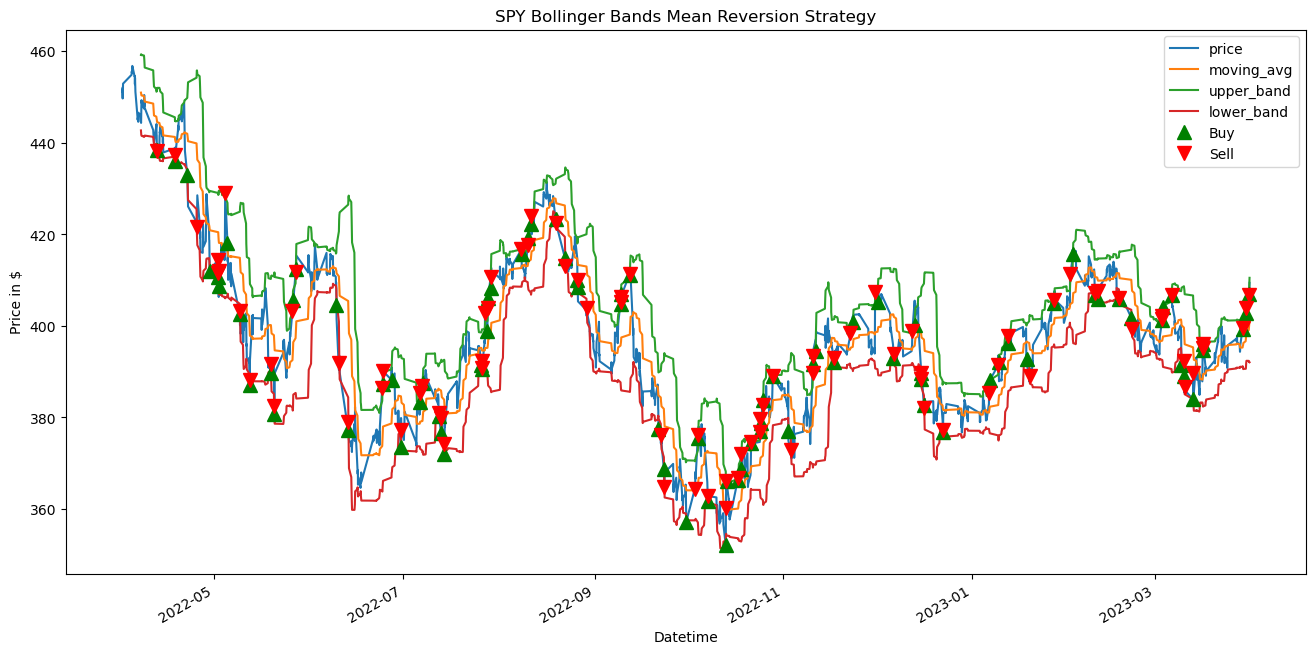

Final PnL with new parameters: $545.11


In [36]:
# Parameters for tuning
ticker = 'SPY'
start_date = '2022-04-01'
end_date = '2023-04-01'
initial_investment = 500
transaction_fee_per_share = 0.005

# Tune parameters
best_params, best_profit_rate = tune_parameters(ticker, start_date, end_date, initial_investment, transaction_fee_per_share)
print(f"Best Parameters: {best_params}, Best Profit Rate: {best_profit_rate:.4f}")

# Implement the Bollinger Bands mean reversion strategy with the new parameters
def implement_strategy_with_new_params(ticker, start_date, end_date, best_params, initial_investment, transaction_fee_per_share):
    window = best_params['window']
    num_std_dev = best_params['num_std_dev']

    stock_data = download_data(ticker, start_date, end_date)
    signals = bollinger_bands_mean_reversion(stock_data, window, num_std_dev)
    signals = calculate_pnl(signals, initial_investment, transaction_fee_per_share)

    return signals

# Use the new parameters in the strategy
new_signals = implement_strategy_with_new_params(ticker, start_date, end_date, best_params, initial_investment, transaction_fee_per_share)

# Plot the stock price and buy/sell signals with new parameters
plot_signals(new_signals, ticker)

print(f"Final PnL with new parameters: ${new_signals['total'][-1]:.2f}")

In [57]:
def generate_signals(stock_data, window, num_std_dev):
    # Calculate the moving average and standard deviation
    stock_data['moving_average'] = stock_data['Adj Close'].rolling(window=window).mean()
    stock_data['moving_std_dev'] = stock_data['Adj Close'].rolling(window=window).std()

    # Calculate the upper and lower Bollinger Bands
    stock_data['upper_band'] = stock_data['moving_average'] + (stock_data['moving_std_dev'] * num_std_dev)
    stock_data['lower_band'] = stock_data['moving_average'] - (stock_data['moving_std_dev'] * num_std_dev)

    # Initialize the 'signals' DataFrame with the 'signal' column
    signals = pd.DataFrame(index=stock_data.index)
    signals['signal'] = 0.0

    # Create buy signals (1) when the closing price is below the lower band
    signals['signal'][stock_data['Adj Close'] < stock_data['lower_band']] = 1.0

    # Create sell signals (-1) when the closing price is above the upper band
    signals['signal'][stock_data['Adj Close'] > stock_data['upper_band']] = -1.0

    # Return the resulting signals
    return signals


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'moving_average',
       'moving_std_dev', 'upper_band', 'lower_band'],
      dtype='object')
                                 Open        High         Low       Close  \
Datetime                                                                    
2022-04-01 09:30:00-04:00  453.309998  453.459991  450.799988  451.100006   
2022-04-01 10:30:00-04:00  451.070007  452.429993  450.799988  451.695007   
2022-04-01 11:30:00-04:00  451.690002  451.750000  449.670013  450.429993   
2022-04-01 12:30:00-04:00  450.429993  450.440002  449.140015  449.660004   
2022-04-01 13:30:00-04:00  449.649994  452.209991  449.554993  452.149994   

                            Adj Close    Volume  moving_average  \
Datetime                                                          
2022-04-01 09:30:00-04:00  451.100006  14902272             NaN   
2022-04-01 10:30:00-04:00  451.695007   7587118             NaN   
2022-04-01 11:30:00-04:00  450.42999

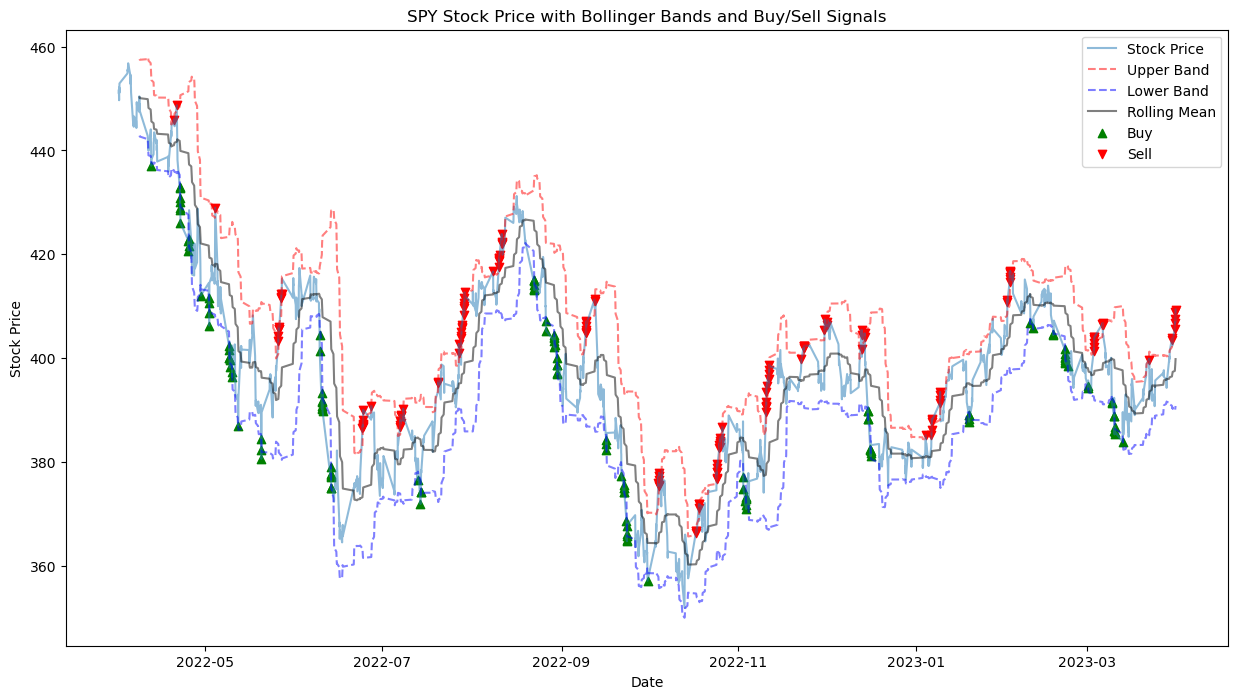

In [58]:
def plot_performance(stock_data, window, num_std_dev, signals):
    # Calculate the Bollinger Bands
    rolling_mean = stock_data['Adj Close'].rolling(window=window).mean()
    rolling_std = stock_data['Adj Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)

    # Create a new DataFrame for plotting
    plot_data = stock_data.copy()
    plot_data['Buy'] = np.where(signals['signal'] == 1, stock_data['Adj Close'], np.nan)
    plot_data['Sell'] = np.where(signals['signal'] == -1, stock_data['Adj Close'], np.nan)
    plot_data['Upper Band'] = upper_band
    plot_data['Lower Band'] = lower_band
    plot_data['Rolling Mean'] = rolling_mean

    # Plot the stock price, Bollinger Bands, and buy/sell signals
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.plot(plot_data.index, plot_data['Adj Close'], label='Stock Price', alpha=0.5)
    ax1.plot(plot_data.index, plot_data['Upper Band'], label='Upper Band', linestyle='--', color='red', alpha=0.5)
    ax1.plot(plot_data.index, plot_data['Lower Band'], label='Lower Band', linestyle='--', color='blue', alpha=0.5)
    ax1.plot(plot_data.index, plot_data['Rolling Mean'], label='Rolling Mean', linestyle='-', color='black', alpha=0.5)
    ax1.scatter(plot_data.index, plot_data['Buy'], label='Buy', marker='^', color='green', alpha=1)
    ax1.scatter(plot_data.index, plot_data['Sell'], label='Sell', marker='v', color='red', alpha=1)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price')
    ax1.set_title(f'{ticker} Stock Price with Bollinger Bands and Buy/Sell Signals')
    ax1.legend()
    plt.show()

# Download data
stock_data = download_data(ticker, start_date, end_date)

# Generate signals with the best parameters
signals = generate_signals(stock_data, best_params['window'], best_params['num_std_dev'])

print(stock_data.columns)
print(stock_data.head())
print(signals.head())

# Plot the performance
plot_performance(stock_data, best_params['window'], best_params['num_std_dev'], signals)



In [40]:
# Q algorithm
alpha = 0.1
gamma = 0.99
epsilon = 0.1
num_episodes = 10

# Define the action space
actions = list(range(-2, 3))

# Initialize Q-Table
state_space = {
    'window': list(range(10, 51, 5)),
    'num_std_dev': np.arange(1.5, 2.6, 0.1)
}
q_table = np.zeros((len(state_space['window']), len(state_space['num_std_dev']), len(actions)))

# Epsilon-greedy action selection
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(actions)
    else:
        return np.argmax(q_table[state[0], state[1], :])

# Update Q-Table
def update_q_table(state, action, reward, new_state):
    q_table[state[0], state[1], action] += alpha * (reward + gamma * np.max(q_table[new_state[0], new_state[1], :]) - q_table[state[0], state[1], action])

# Reinforcement Learning Algorithm
for episode in range(num_episodes):
    window_index = np.random.choice(len(state_space['window']))
    num_std_dev_index = np.random.choice(len(state_space['num_std_dev']))
    state = (window_index, num_std_dev_index)

    for step in range(100):
        action = choose_action(state, epsilon)

        new_window_index = max(min(window_index + actions[action], len(state_space['window']) - 1), 0)
        new_num_std_dev_index = max(min(num_std_dev_index + actions[action], len(state_space['num_std_dev']) - 1), 0)
        new_state = (new_window_index, new_num_std_dev_index)

        _, reward, _ = backtest_strategy(ticker, start_date, end_date, state_space['window'][new_window_index], state_space['num_std_dev'][new_num_std_dev_index], initial_investment, transaction_fee_per_share, n=1)

        update_q_table(state, action, reward, new_state)

        state = new_state

# Get the best parameters from the Q-Table
best_params_indices = np.unravel_index(np.argmax(q_table, axis=None), q_table.shape)
best_params = {
    'window': state_space['window'][best_params_indices[0]],
    'num_std_dev': state_space['num_std_dev'][best_params_indices[1]]
}

print(f"Best Parameters: {best_params}")



1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, symbol may be delisted

1 Failed download:
- SPY: No data found for this date range, sym

# Deep Q Algorithm

import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, buffer_size=10000, batch_size=64):
        self.q_net = QNetwork(state_dim, action_dim).to(device)
        self.target_net = QNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.loss_fn = nn.MSELoss()

    def update(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        if len(self.buffer) < self.batch_size:
            return

        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

        curr_q_values = self.q_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1, keepdim=True)[0].detach()
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.loss_fn(curr_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def select_action(self, state, epsilon=0.1):
        if random.random() < epsilon:
            return random.randint(0, 1)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = self.q_net(state)
            return q_values.argmax(dim=1).item()

    def update_target_net(self):
        self.target_net.load_state_dict(self.q_net.state_dict())
def train_dqn(agent, ticker, start_date, end_date, initial_investment, transaction_fee_per_share, n, num_episodes, target_update_freq):
    for episode in range(num_episodes):
        print(f"Episode {episode + 1}/{num_episodes}")
        state = get_state()  # Define the get_state() function to create a state representation
        done = False

        while not done:
            action = agent.select_action(state)
            # Apply the action to the environment and get the new state, reward, and done flag
            next_state, reward, done = apply_action(state, action, ticker, start_date, end_date, initial_investment, transaction_fee_per_share, n)

            agent.update(state, action, reward, next_state, done)
            state = next_state

        if (episode + 1) % target_update_freq == 0:
            agent.update_target_net()
state_dim = 2  # The dimension of the state representation
action_dim = 2  # The number of possible actions (e.g., increase or decrease window size and num_std_dev)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(state_dim, action_dim)
num_episodes = 100
target_update_freq = 10

train_dqn(agent, ticker, start_date, end_date, initial_investment, transaction_fee_per_share, n, num_episodes, target_update_freq)
